In [56]:
import requests  
from bs4 import BeautifulSoup
import pandas as pd 
import datetime

In [57]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

url = "https://www.ebay.com/b/Electronics/bn_7000259124"

# Create a session
session = requests.Session()
retry = Retry(total=5, backoff_factor=1, status_forcelist=[429, 500, 502, 503, 504])
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

try:
	respons = session.get(url)
	print(respons.status_code)
except requests.exceptions.RequestException as e:
	print(f"Error: {e}")

200


In [58]:
soup_main_page = BeautifulSoup (respons.content , "lxml")
all_product_li_tag = soup_main_page.find('ul' , attrs={'class':'brwrvr__item-results brwrvr__item-results--list'}).findAll('li' , attrs={'class':'brwrvr__item-card brwrvr__item-card--list'})
products_url =[]
for each in all_product_li_tag:
    products_url.append(each.find('a' , attrs = {'class': 'bsig__title__wrapper'}).get('href'))

In [59]:
products_url

['https://www.ebay.com/itm/334234590018?_skw=Electronics&epid=223459468&hash=item4dd1ef1b42:g:25sAAOSwm2peCkI6&itmprp=enc%3AAQAKAAAA8MHg7L1Zz0LA5DYYmRTS30nwb1iUKJI7k3JBE7dmVohQco7Hn6mTb%2BbyGIa76hVDEDhg5HEUhj6R7BN%2FurxyN%2F00W%2BIZa8AeEKd7AW2Y%2FoYSHZtb41IhqAirToQoCDO3Gze8jp9RZdUp358ufGNuI%2F577aasrYqEpoUX1BgHaW7PZKmLbsxTX7gI2QaihfAOlXQDEYxUoQ6Ff%2FKBr1vItFvoDBFWfIDfOxUSvfgtwN96c5K1S6Xl9dvyZEuOZVKL8fz%2FqnIiaDoZ%2BCyYbYZZ2fMrjrLYCCQc2%2FVj7dz00E8rkAG2nfAVl7GqncIT5%2FdR4g%3D%3D%7Ctkp%3ABFBMwv6P_adl',
 'https://www.ebay.com/itm/365416641718?_skw=Electronics&hash=item55148774b6:g:c-wAAeSwqwZnu-lY&itmprp=enc%3AAQAKAAAA8MHg7L1Zz0LA5DYYmRTS30kzDLyw0SwaUfQh3amyD3NnXUMyoLou7pWDOYGGylJljUgrYKGs3od4se2aYyAlDUOhm9%2BymiuxpoJnZfa7C1RONxrjnjWwXbERCdMvs%2B%2BNpe8GpZocsO5UQFz0QwsREEBqMfoReIgKlET9MNyHY%2B6y4wqANO5jKGD%2BZdvKtOXimtOw52D%2FPB3CXNas2fMxvIJL7%2B4mLRGRRn6TIHA3JQuprFewyJd7jaNHzTkjdWKQ5l7DpxWP6dODUd2fQmr66EQqnqwuhZwRI3aAMTC3v5bEKP8cq02PKsn%2Fn1uZ3rayLQ%3D%3D%7Ctkp%3ABk9SR8L-j_2nZQ',
 'https

In [60]:
products_soup = []
for url in products_url:
   respons =requests.get(url)
   products_soup.append(BeautifulSoup(respons.content , 'lxml'))

In [61]:
culmns = {'name' : [] , 'price_(USD)' :[] , 'stock':[] , 'Sold':[] , 'date_status':[]}
i = 0
for each in products_soup:
    title = each.find('h1' , attrs={'class':'x-item-title__mainTitle'})
    culmns['name'].append(title.text if title else None)
    
    price_div = each.find('div' , attrs={'class':'x-bin-price__content'})
    if price_div:
        price_primary = price_div.find('div' , attrs={'class':'x-price-primary' , 'data-testid':'x-price-primary'})
        if price_primary:
            price_span = price_primary.find('span' ,attrs={'class':'ux-textspans'})
            culmns['price_(USD)'].append(price_span.text if price_span else None)
        else:
            culmns['price_(USD)'].append(None)
    else:
        culmns['price_(USD)'].append(None)
    stock_div = each.find('div' , attrs={'class':'x-quantity__availability' , 'id' :'qtyAvailability'})
    if stock_div:
        stock_span = stock_div.find('span' ,attrs={'class':'ux-textspans ux-textspans--SECONDARY'})
    culmns['stock'].append(stock_span.text if stock_span else 0)
    sold_div = stock_div
    if sold_div:
        sold_span = sold_div.find('span' , attrs={'class':'ux-textspans ux-textspans--BOLD ux-textspans--EMPHASIS'})
    culmns['Sold'].append(sold_span.text if sold_span  else 0)
    if culmns['Sold'][i] == 'Last one':
        culmns['Sold'][i] = None
    culmns['date_status'].append(datetime.date.today().strftime("%Y-%m-%d"))
    i+=1

In [62]:
import re
length = len(culmns['price_(USD)']) # cleaning price column 
for i in range(length):
    if culmns['price_(USD)'][i]:
        get_price = float(re.findall(r'\d+\.\d+|\d+' , str(culmns['price_(USD)'][i]))[0])
    else :
        get_price = 0.0
    if re.findall(r"\d+" , str(culmns['stock'][i])) :
        get_availible = int(re.findall(r"\d+" , str(culmns['stock'][i]))[0]) 
    else:
        get_availible = 0
    get_sold = re.findall(r"\d+|\d+\,\d+" , str(culmns['Sold'][i]))
    if len(get_sold) == 2:
        get_sold_ = int(get_sold[0]+get_sold[1])
    elif len(get_sold) == 1 :
        get_sold_ = int(get_sold[0])
    else :
        get_sold_ = 0
    # print(type(get_sold_)) # class int
    culmns['stock'][i]= get_availible
    
    culmns['price_(USD)'][i]= get_price
    culmns['Sold'][i] = get_sold_

In [63]:
df = pd .DataFrame(culmns)

In [64]:
df

,name,price_(USD),stock,Sold,date_status
0,Nintendo Wii Video Game System RVL-001 Console...,123.45,170,2441,2025-02-26
1,Retro Handheld RANDOM COLOR Video Game Console...,40.25,8,0,2025-02-26
2,Retro Game Mini Game Anniversary Edition Enter...,18.99,6,0,2025-02-26
3,Nintendo DS Lite Authentic DSL Console Handhel...,9.99,10,4025,2025-02-26
4,Nintendo 3DS / 3DS XL LL Region Free USA Selle...,144.00,0,0,2025-02-26
5,4K HDMI TV Game Stick Built-in 64GB 30000+ Vid...,20.89,3,45,2025-02-26
6,Sony PSP Go PSP-1001 PlayStation Portable - Black,0.00,3,45,2025-02-26
7,R36S Retro Handheld Video Game Console Linux S...,42.99,4,79,2025-02-26
8,Video Game Console Retro 30000+ Games TV Stick...,35.05,10,198,2025-02-26
9,4K 64G HDMI TV Video Game Stick M15 Gaming Con...,23.89,10,0,2025-02-26


In [65]:
df.dropna(subset=["Sold"], inplace=True)

In [66]:
# df.to_excel(r'C:\Users\rabat\OneDrive\data.xlsx', index=False)

In [67]:
l = len(df['stock'])
for i in range(l):
    if int(df.iloc[i]['stock']) == 0 and int(df.iloc[i]['Sold']) == 0:
        df.at[i, 'Sold'] = None
df.dropna(subset=['Sold'], inplace=True)
df['Sold'] = df['Sold'].astype(int)

In [68]:
df.to_csv('data.csv', index=False)

In [69]:
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import create_engine
import pandas as pd
import urllib.parse

In [78]:
import warnings
warnings.filterwarnings('ignore')
from sqlalchemy import create_engine , Text , Date , Float , Integer
import pandas as pd
import urllib.parse
username = 'root'
password = urllib.parse.quote_plus('Chicken@id1@@')   # this line is not necessary if your password does not end with @
host = 'localhost'
port = '3306'
database = 'ebayData'

dtype = {
    'name':Text() ,
    'price_(USD)':Float,
    'stock' : Integer,
    'Sold': Integer,
    'date_status' :Date
}

engine = create_engine(f"mysql+mysqldb://{username}:{password}@{host}:{port}/{database}")

conn = engine.connect()

data = pd.read_csv("data.csv")

data['date_status'] = pd.to_datetime(data['date_status'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')

data.to_sql('electronic', engine, index=False, if_exists='append' , dtype=dtype)
conn.close()

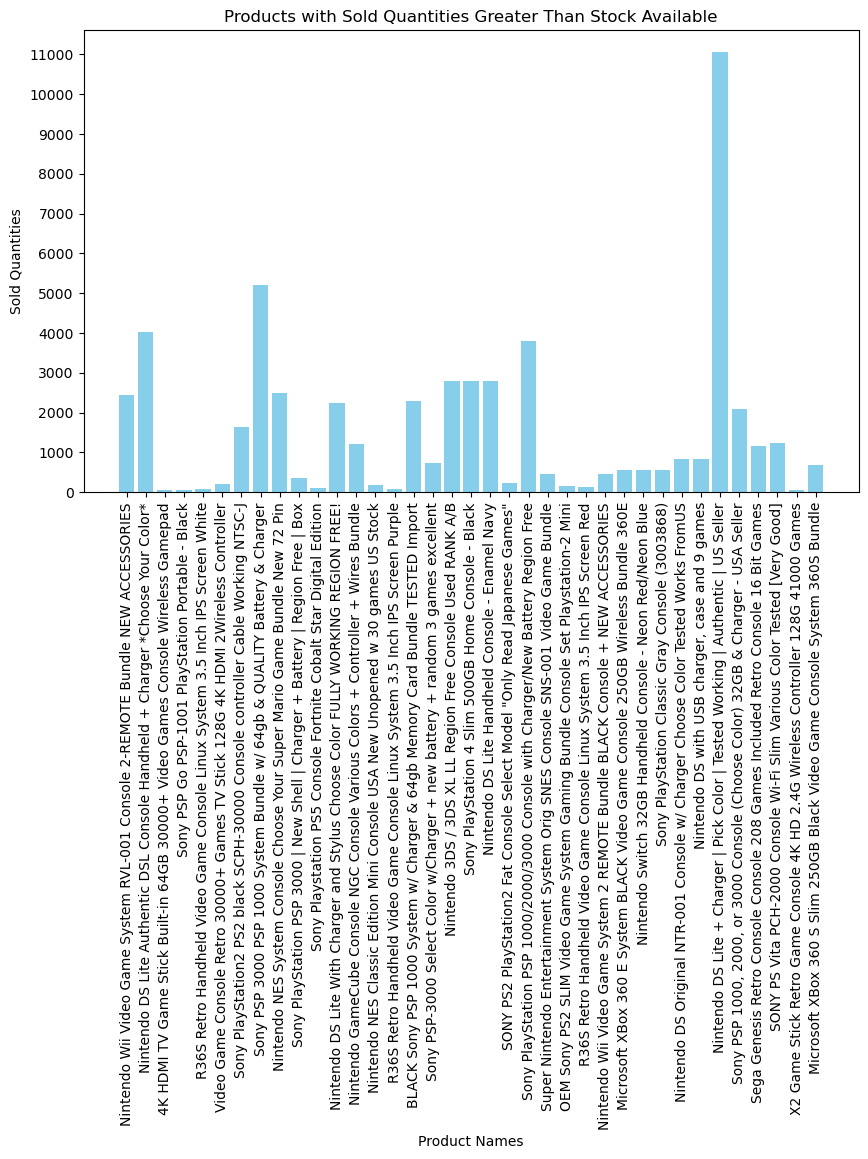

In [79]:
import matplotlib.pyplot as plt

prd_name = []
prd_Sold_great = []

df.reset_index(drop=True, inplace=True)

for i in range(len(df)):
    if df.at[i, 'Sold'] > df.at[i, 'stock']:
        prd_name.append(df.at[i, 'name'])
        prd_Sold_great.append(df.at[i, 'Sold'])

plt.figure(figsize=(10, 6))
plt.bar(prd_name, prd_Sold_great, color='skyblue')
plt.xlabel('Product Names')
plt.ylabel('Sold Quantities')
plt.title('Products with Sold Quantities Greater Than Stock Available')
plt.xticks(rotation=90)
plt.yticks(range(0, max(prd_Sold_great) + 1,1000 )) 
plt.show()

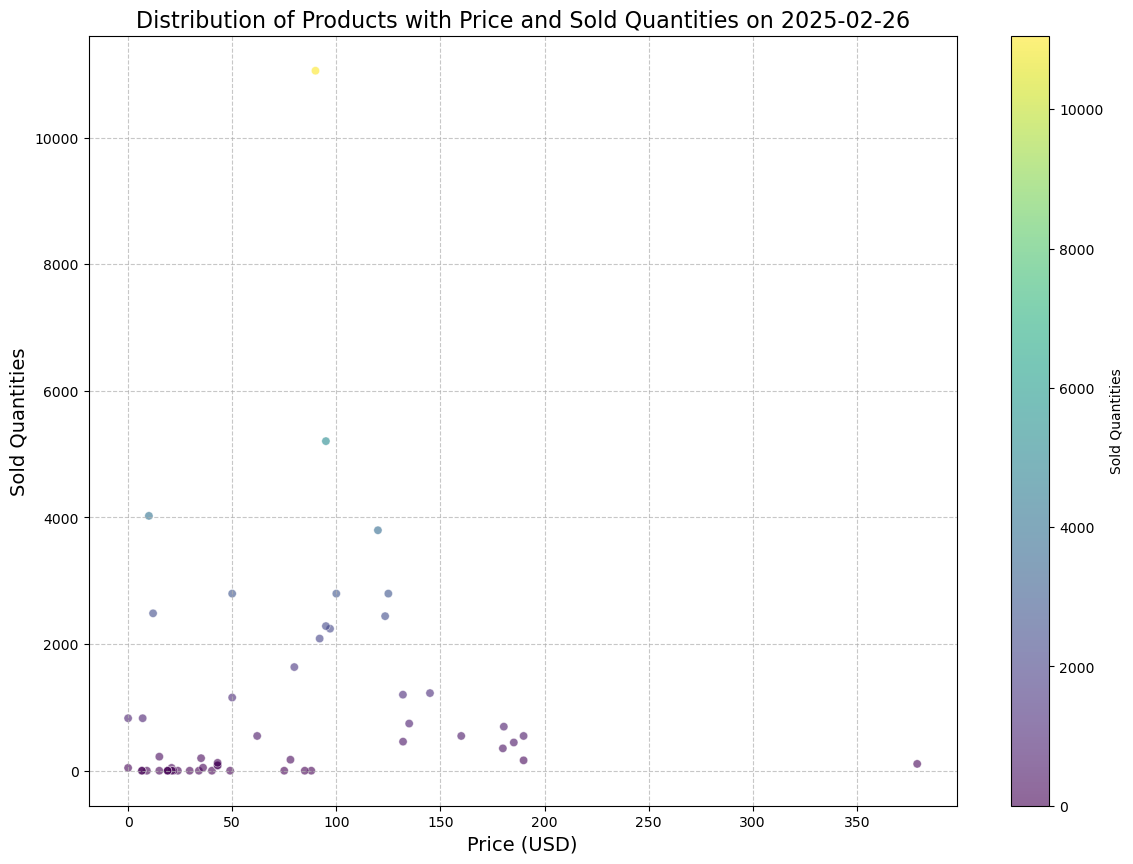

In [80]:
import matplotlib.pyplot as plt
import datetime
specific_date = '2025-02-26'  # Replace with the desired date
filtered_df = df[df['date_status'] == specific_date]

product_prices = filtered_df['price_(USD)']
product_sold = filtered_df['Sold']

plt.figure(figsize=(14, 10))
scatter = plt.scatter(product_prices, product_sold, alpha=0.6, c=product_sold, cmap='viridis', edgecolors='w', linewidth=0.5)

cbar = plt.colorbar(scatter)
cbar.set_label('Sold Quantities')

plt.xlabel('Price (USD)', fontsize=14)
plt.ylabel('Sold Quantities', fontsize=14)
plt.title(f'Distribution of Products with Price and Sold Quantities on {specific_date}', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


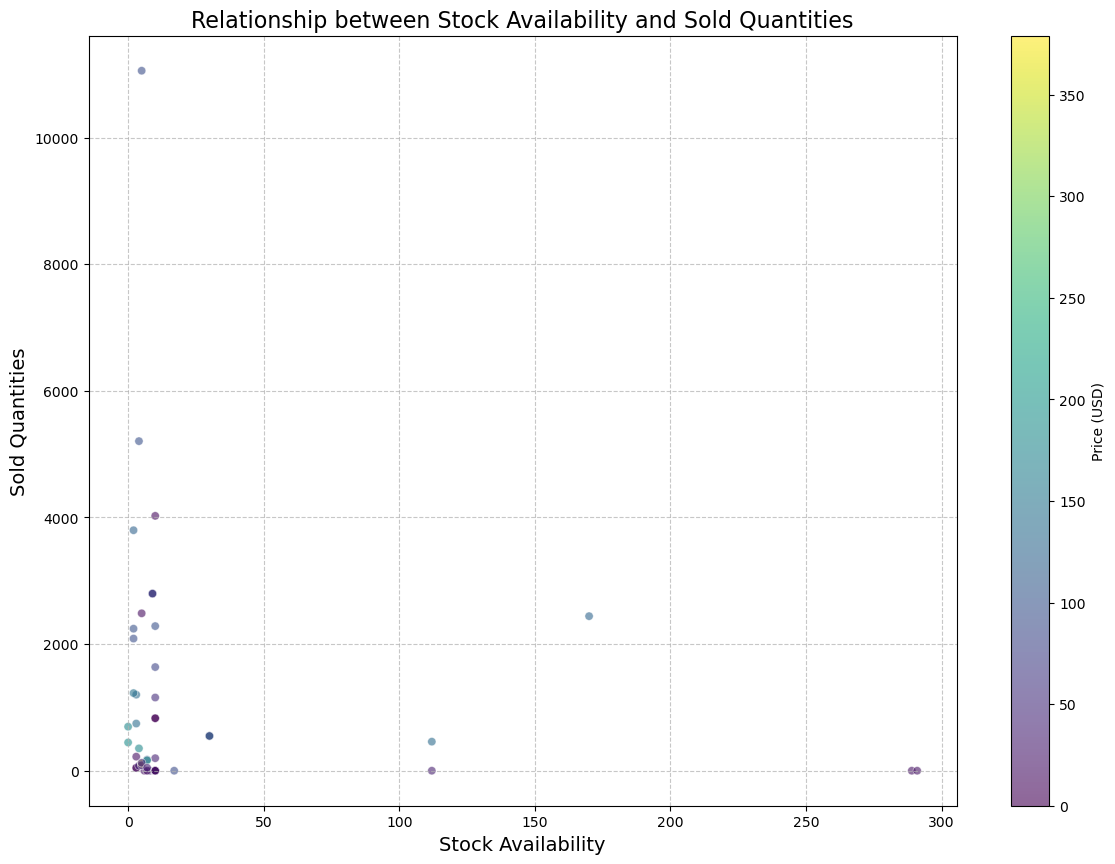

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
scatter = plt.scatter(df['stock'], df['Sold'], alpha=0.6, c=df['price_(USD)'], cmap='viridis', edgecolors='w', linewidth=0.5)

cbar = plt.colorbar(scatter)
cbar.set_label('Price (USD)')

plt.xlabel('Stock Availability', fontsize=14)
plt.ylabel('Sold Quantities', fontsize=14)
plt.title('Relationship between Stock Availability and Sold Quantities', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()